# Data Preprocessing

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
df = pd.read_csv('storms.csv', sep=',')

In [4]:
df['nameyear'] = df['name'] + '-' + df['year'].astype(str)

In [5]:
temp = df.groupby('nameyear').first()
temp['maxcategory'] = df.groupby('nameyear')['category'].max()

In [6]:
temp['minor_major'] = 'none'
temp.loc[temp['maxcategory'] > 3, 'minor_major'] = 'major'
temp.loc[(temp['maxcategory'] <= 3) & (temp['maxcategory'] > 0), 'minor_major'] = 'minor'
temp

,name,year,month,day,hour,lat,long,status,category,wind,pressure,ts_diameter,hu_diameter,maxcategory,minor_major
nameyear,,,,,,,,,,,,,,,
AL011993-1993,AL011993,1993,5,31,12,21.5,-84.0,tropical depression,-1,25,1003,NaN,NaN,-1,none
AL012000-2000,AL012000,2000,6,7,18,21.0,-93.0,tropical depression,-1,25,1008,NaN,NaN,-1,none
AL021992-1992,AL021992,1992,6,25,12,24.5,-85.5,tropical depression,-1,25,1009,NaN,NaN,-1,none
AL021994-1994,AL021994,1994,7,20,6,32.2,-78.9,tropical depression,-1,25,1017,NaN,NaN,-1,none
AL021999-1999,AL021999,1999,7,2,18,20.2,-95.0,tropical depression,-1,30,1006,NaN,NaN,-1,none
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Wilfred-2020,Wilfred,2020,9,17,18,10.8,-28.1,tropical storm,0,35,1007,149.6014,0.0,0,none
Wilma-2005,Wilma,2005,10,15,18,17.6,-78.5,tropical depression,-1,25,1004,0.0000,0.0,5,major
Zeta-2005,Zeta,2005,12,30,0,23.9,-35.6,tropical depression,-1,30,1009,0.0000,0.0,0,none


In [7]:
filtered = temp.filter(items=['nameyear', 'name', 'year', 'maxcategory', 'minor_major'])
filtered['event'] = 1
filtered['date'] = pd.to_datetime(filtered['year'], format='%Y')

filtered = filtered.set_index('date').sort_index()

In [8]:
filtered

,name,year,maxcategory,minor_major,event
date,,,,,
1975-01-01,Doris,1975,2,minor,1
1975-01-01,Amy,1975,0,none,1
1975-01-01,Caroline,1975,3,minor,1
1976-01-01,Belle,1976,3,minor,1
1976-01-01,Gloria,1976,2,minor,1
...,...,...,...,...,...
2020-01-01,Fay,2020,0,none,1
2020-01-01,Beta,2020,0,none,1
2020-01-01,Sally,2020,2,minor,1


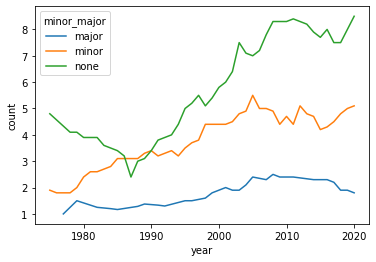

In [51]:
data = filtered.groupby(['minor_major', 'year'])['name'].nunique().rolling(10, 1).mean().to_frame(name = 'count').reset_index()

sns.lineplot(x='year', y='count', hue='minor_major', data=data)

data.to_csv('frequency.csv', index=False)

In [10]:
# Transform to seasonality chart
m_filtered = temp.filter(items=['nameyear', 'name', 'year', 'month', 'day', 'maxcategory', 'minor_major'])
m_filtered['event'] = 1
m_filtered['date'] = pd.to_datetime(m_filtered[['year', 'month', 'day']])

m_filtered = m_filtered.set_index('date').sort_index()
m_filtered

,name,year,month,day,maxcategory,minor_major,event
date,,,,,,,
1975-06-27,Amy,1975,6,27,0,none,1
1975-08-24,Caroline,1975,8,24,3,minor,1
1975-08-29,Doris,1975,8,29,2,minor,1
1976-08-06,Belle,1976,8,6,3,minor,1
1976-09-26,Gloria,1976,9,26,2,minor,1
...,...,...,...,...,...,...,...
2020-10-19,Epsilon,2020,10,19,3,minor,1
2020-10-24,Zeta,2020,10,24,3,minor,1
2020-10-31,Eta,2020,10,31,4,major,1


In [11]:
from functools import reduce
data2 = m_filtered.groupby(['minor_major', 'month'])['name'].nunique().to_frame(name='count').reset_index()

dfs = []
for name, data in data2.groupby('minor_major'):
    months = pd.DataFrame({'month': range(1,13)})
    months = months.merge(data, how='left')
    months['minor_major'] = name

    if np.isnan(months['count'][0]):
        months['count'][0] = 0

    months[name] = months['count'].interpolate()
    months[name] = months[name].round(2)
    months = months.filter(['month', name])
    dfs.append(months)
data2 = reduce(lambda l, r: pd.merge(l, r, on=['month'], how='outer'), dfs)

# data2.to_csv('frequency_months.csv', index=False)

C:\Users\admin\AppData\Local\Temp/ipykernel_17196/134857459.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  months['count'][0] = 0


In [12]:
import datetime
from dateutil import rrule

start = datetime.date(2000, 1, 1)
end = datetime.date(2000, 12, 31)

days = [(start + datetime.timedelta(days=x)).strftime('%m-%d') for x in range((end-start).days + 1)]


In [13]:
data3 = m_filtered
data3['monthday'] = data3.apply(lambda row: str(row['month']).zfill(2) + '-' + str(row['day']), axis=1)

data3 = data3.reset_index()

dfs = []
for name, data in data3.groupby('minor_major'):
    days = [(start + datetime.timedelta(days=x)).strftime('%m-%d') for x in range((end-start).days + 1)]
    days = pd.DataFrame({'monthday': days})

    days = pd.merge(days, data, how='left', on='monthday')

    days[name] = days['event'].replace(np.nan, 0)
    days[name] = days[name].rolling(30, 1).sum()
    
    days = days.filter(['monthday', name])
    dfs.append(days)

data3 = reduce(lambda l, r: pd.merge(l, r, on=['monthday'], how='outer'), dfs)
data3 = data3[~data3['monthday'].duplicated(keep='last')]
data3.to_csv('frequency_months_daily.csv', index=False)

display(data3)

,monthday,major,minor,none
0,01-01,0.0,0.0,0.0
1,01-02,0.0,0.0,0.0
2,01-03,0.0,0.0,0.0
3,01-04,0.0,0.0,0.0
4,01-05,0.0,0.0,0.0
...,...,...,...,...
633,12-27,0.0,2.0,3.0
634,12-28,0.0,2.0,2.0
635,12-29,0.0,1.0,2.0
636,12-30,0.0,1.0,2.0


In [48]:
calc = df

calc['date'] = pd.to_datetime(calc[['year', 'month', 'day', 'hour']])

calc['maxcategory'] = calc.groupby('nameyear')['category'].transform('max')
calc['startdate'] = calc.groupby('nameyear')['date'].transform('min')
calc['hours_since_start'] = (calc['date'] - calc['startdate']) / np.timedelta64(1, 'h')
calc['minor_major'] = 'none'
calc.loc[calc['maxcategory'] > 3, 'minor_major'] = 'major'
calc.loc[(calc['maxcategory'] <= 3) & (calc['maxcategory'] > 0), 'minor_major'] = 'minor'

print(calc)

       name  year  month  day  hour   lat  long               status  \
0       Amy  1975      6   27     0  27.5 -79.0  tropical depression   
1       Amy  1975      6   27     6  28.5 -79.0  tropical depression   
2       Amy  1975      6   27    12  29.5 -79.0  tropical depression   
3       Amy  1975      6   27    18  30.5 -79.0  tropical depression   
4       Amy  1975      6   28     0  31.5 -78.8  tropical depression   
...     ...   ...    ...  ...   ...   ...   ...                  ...   
11854  Iota  2020     11   17    12  13.7 -84.7            hurricane   
11855  Iota  2020     11   17    18  13.7 -85.7       tropical storm   
11856  Iota  2020     11   18     0  13.8 -86.7       tropical storm   
11857  Iota  2020     11   18     6  13.8 -87.8       tropical storm   
11858  Iota  2020     11   18    12  13.7 -89.0  tropical depression   

       category  wind  pressure  ts_diameter  hu_diameter   nameyear  \
0            -1    25      1013          NaN          NaN   Amy

In [56]:
dfs = []
for name, data in calc.groupby('minor_major'):
    d = data.groupby('hours_since_start')[['wind', 'pressure']].mean()
    d['wind'] = d['wind'].rolling(10,1).mean().round(2)
    d['pressure'] = d['pressure'].rolling(10,1).mean().round(2)
    d['minor_major'] = name
    # d = d.rename(columns={'wind': name+'_wind', 'pressure': name+'_pressure'})
    dfs.append(d)
data4 = pd.concat(dfs, ignore_index=False)
data4 = data4.reset_index()
data4.to_csv('wind_pressure_hourly.csv', index=False)
data4

,hours_since_start,wind,pressure,minor_major
0,0.0,27.79,1007.77,major
1,6.0,29.30,1007.24,major
2,12.0,30.77,1006.63,major
3,18.0,32.23,1005.92,major
4,20.0,34.79,1004.93,major
...,...,...,...,...
448,312.0,20.30,1005.48,none
449,318.0,18.50,1006.02,none
450,324.0,16.50,1007.15,none
451,330.0,15.75,1007.85,none
